<a href="https://colab.research.google.com/github/carlosherediapimienta/Forecasting/blob/main/Time_Series_FirstSteps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis

In this notebook, we are going to reproduce the notebook: TimeSeries Analysis 📈A Complete Guide 📚 (Keagle) to learn how to implement a time series analysis.



## Read CSV: Aquifer_Auser.csv

In [114]:
import pandas as pd
df = pd.read_csv('/content/Aquifer_Auser.csv', sep = ',')
df.head()

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,...,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
0,05/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,10.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,07/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.2,0.0,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,08/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.4,0.0,13.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,09/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.4,0.0,12.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Manipulation

In [115]:
df = df[df.Rainfall_Pontetetto.notna()].reset_index(drop=True)

# Random Selection columns
selected_columns = ['Date','Rainfall_Pontetetto', 'Depth_to_Groundwater_SAL', 'Temperature_Orentano', 'Volume_POL', 'Hydrometry_Monte_S_Quirico']
df = df.loc[:, selected_columns]

df.columns = df.columns.str.split('_').str[0]

In [116]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

## Data Visualization

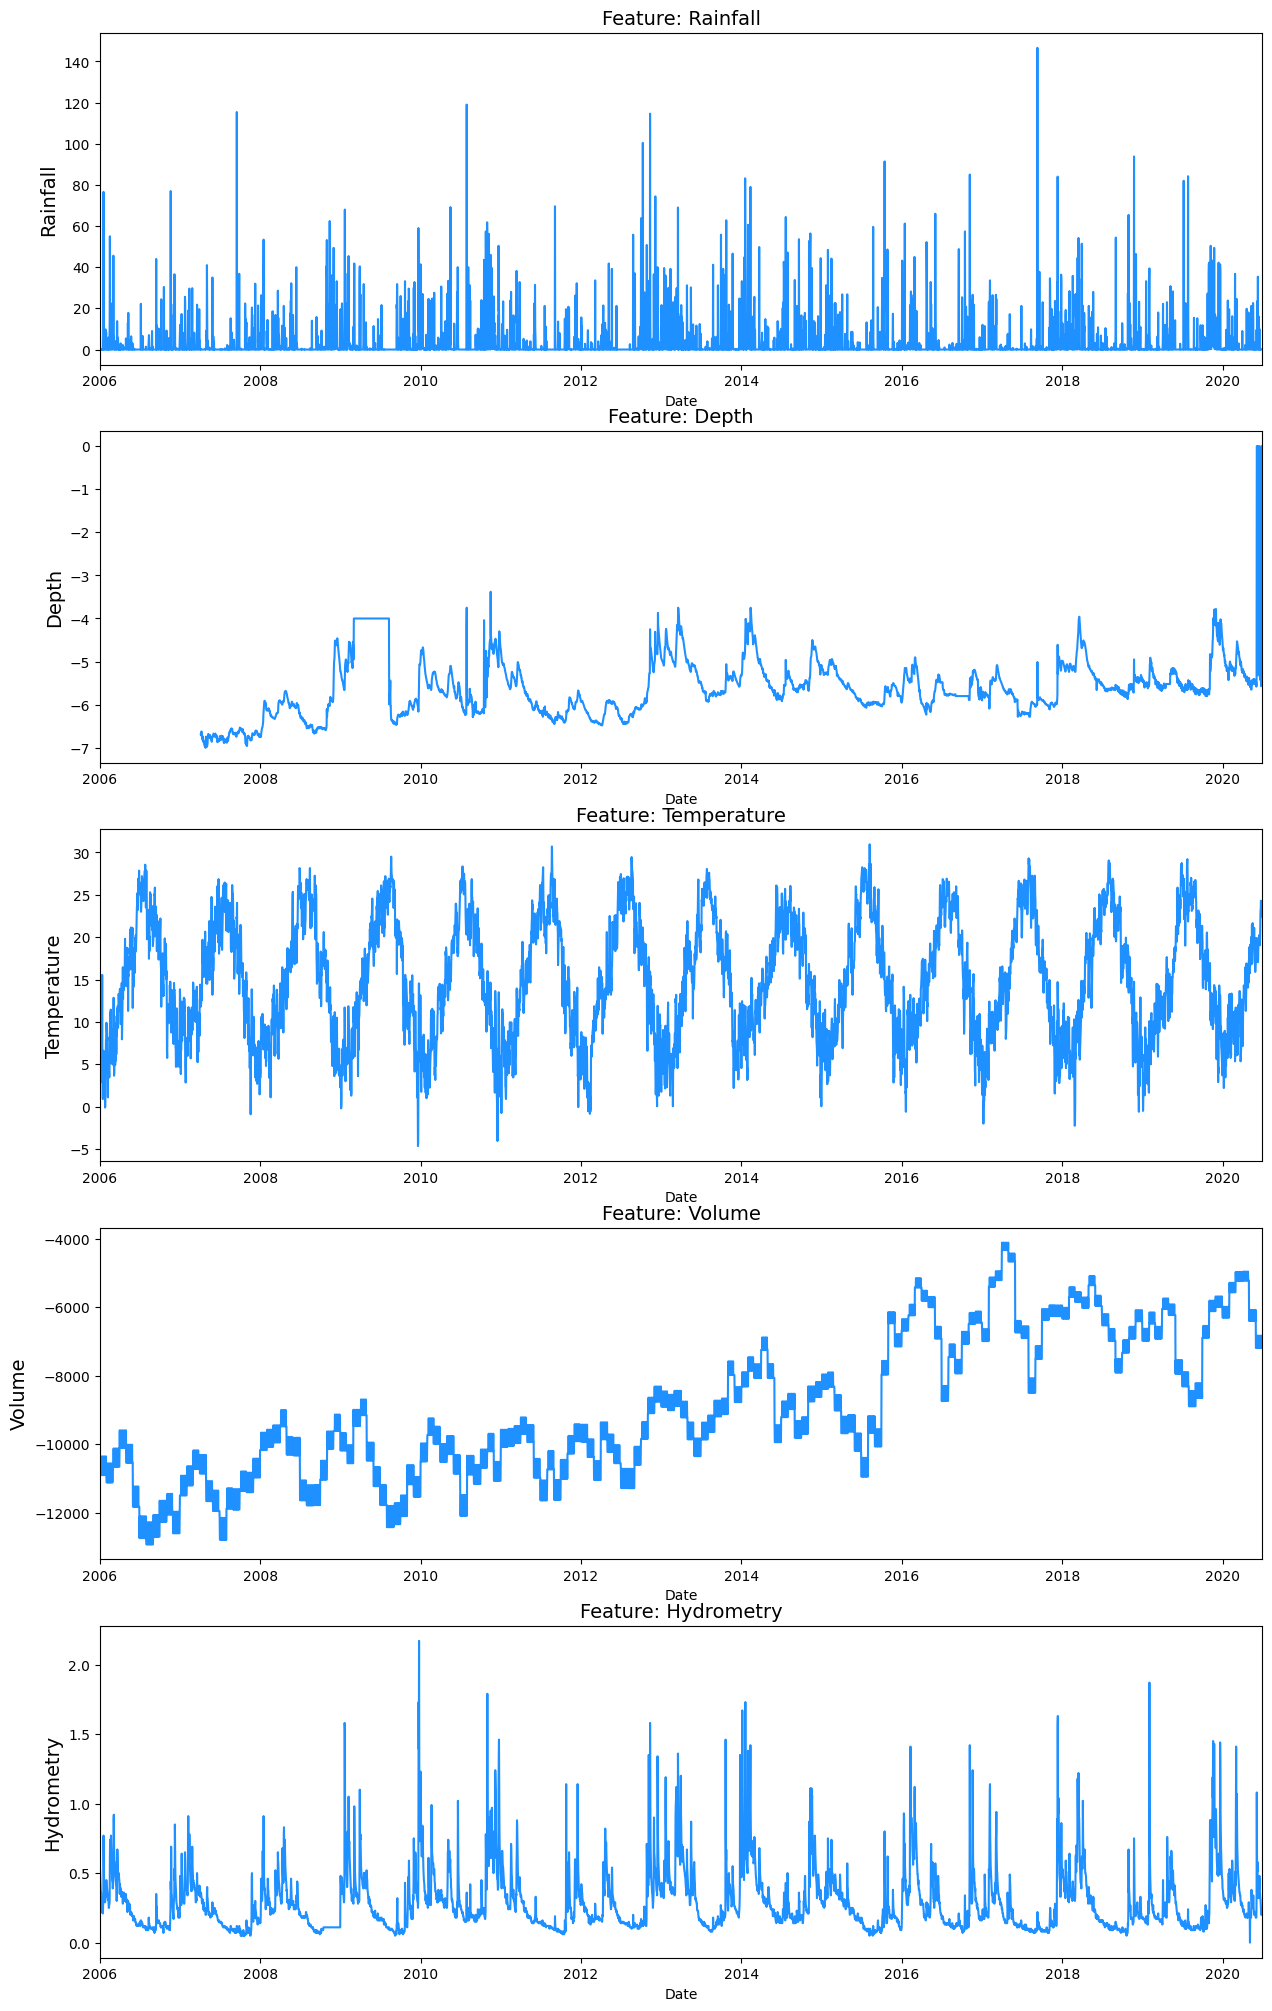

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))
for i, column in enumerate(df.drop('Date', axis=1).columns):
    sns.lineplot(x=df['Date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)

    ax[i].set_xlim([date(2006, 1, 1), date(2020, 6, 30)])

## Data Preprocessing

In [120]:
df = df.sort_values(by='Date')
df['Delta'] = df['Date'] - df['Date'].shift(1)
df['Delta'].sum(), df['Delta'].count()

(Timedelta('5294 days 00:00:00'), 5294)

### Handle Missings

In [122]:
df = df.drop('Delta', axis=1)
df.isna().sum()

Date             0
Rainfall         0
Depth          750
Temperature      0
Volume           0
Hydrometry      91
dtype: int64

In [123]:
mean_depth = df['Depth'].mean()

df['Depth'] = df['Depth'].apply(lambda x: mean_depth if pd.isna(x) else x)
df['Hydrometry'] = df['Hydrometry'].interpolate()

## Resampling / Smoothing data

In [127]:
columns_of_interest = ['Date', 'Depth', 'Temperature', 'Volume', 'Hydrometry', 'Rainfall']
selected_columns = df[columns_of_interest]

weekly_downsampled = selected_columns.resample('7D', on='Date').mean().reset_index(drop=False)

df = weekly_downsampled.copy()

## Seasonality

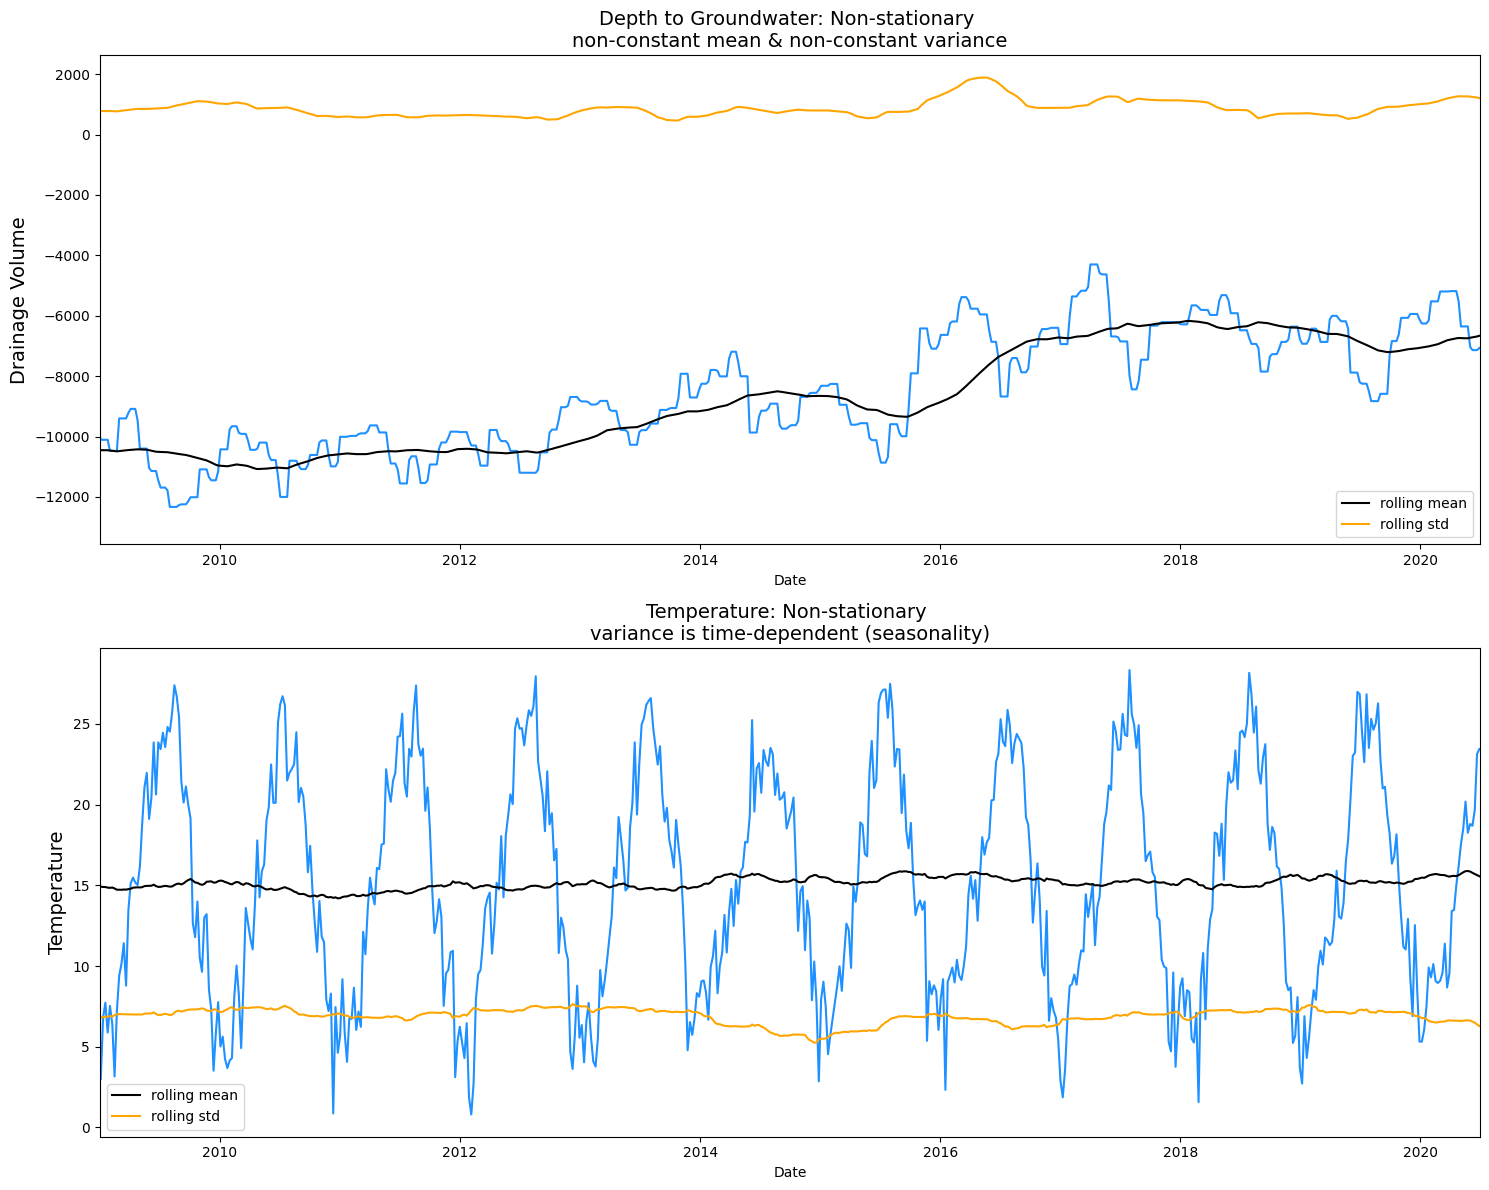

In [129]:
rolling_window = 52

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['Date'], y=df['Volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['Volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['Volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['Date'], y=df['Temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['Temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['Temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

## Augmented Dickey-Fuller (ADF)

The Augmented Dickey-Fuller (ADF) test is a statistical test classified as a unit root test, which is used to assess non-stationarity in a time series. Unit roots indicate a lack of stationarity.

#### Hypotheses:

- **Null Hypothesis (H0):** The time series has a unit root (i.e., it is not stationary).
  
- **Alternate Hypothesis (H1):** The time series has no unit root (i.e., it is stationary).

#### Conclusion:

If the null hypothesis is rejected, it implies that the time series is stationary.

#### Rejection Criteria:

1. **Using p-value:**
   - **p-value > Significance Level (default: 0.05):** Fail to reject the null hypothesis (H0); the data has a unit root and is non-stationary.
   - **p-value ≤ Significance Level (default: 0.05):** Reject the null hypothesis (H0); the data does not have a unit root and is stationary.

2. **Using ADF Statistic and Critical Values:**
   - **ADF Statistic > Critical Value:** Fail to reject the null hypothesis (H0); the data has a unit root and is non-stationary.
   - **ADF Statistic < Critical Value:** Reject the null hypothesis (H0); the data does not have a unit root and is stationary.

In [133]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Depth'].values)
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.995369467515665
n_lags: 2.2666260711580592e-05
p-value: 2.2666260711580592e-05
Critial Values:
   1%, -3.4390641198617864
Critial Values:
   5%, -2.8653859408474482
Critial Values:
   10%, -2.5688179819544312


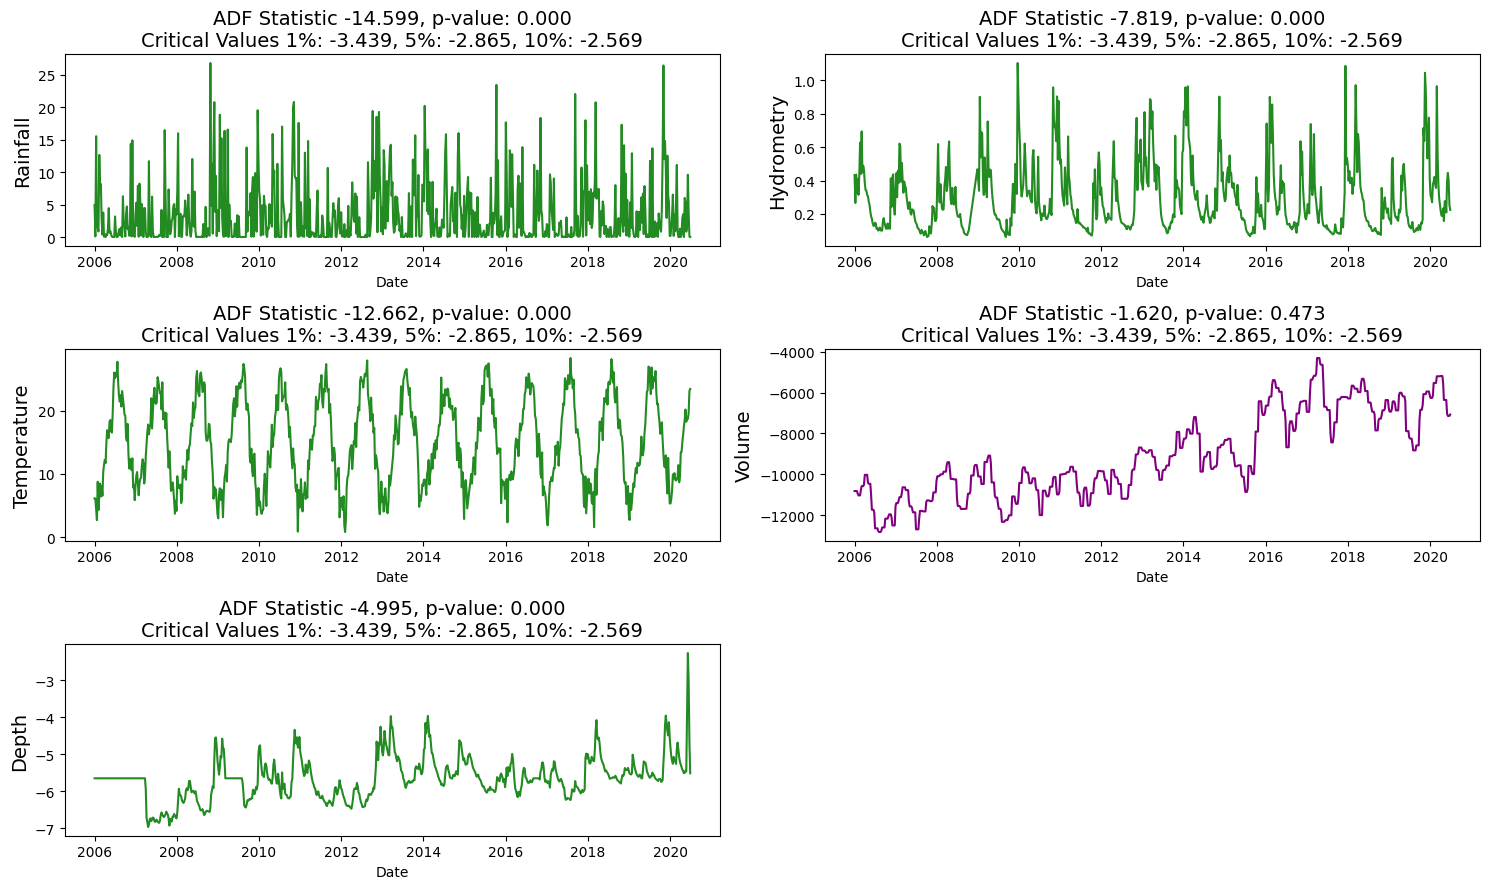

In [134]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['Date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['Rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['Temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['Hydrometry'].values, 'Hydrometry', ax[0, 1])
visualize_adfuller_results(df['Volume'].values, 'Volume', ax[1, 1])
visualize_adfuller_results(df['Depth'].values, 'Depth', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

## Transforming Non-stationary TS to Stationary TS

### LOG

<ipython-input-135-7236039891f1>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Volume_log'], ax=ax[1])


<Axes: xlabel='Volume_log', ylabel='Density'>

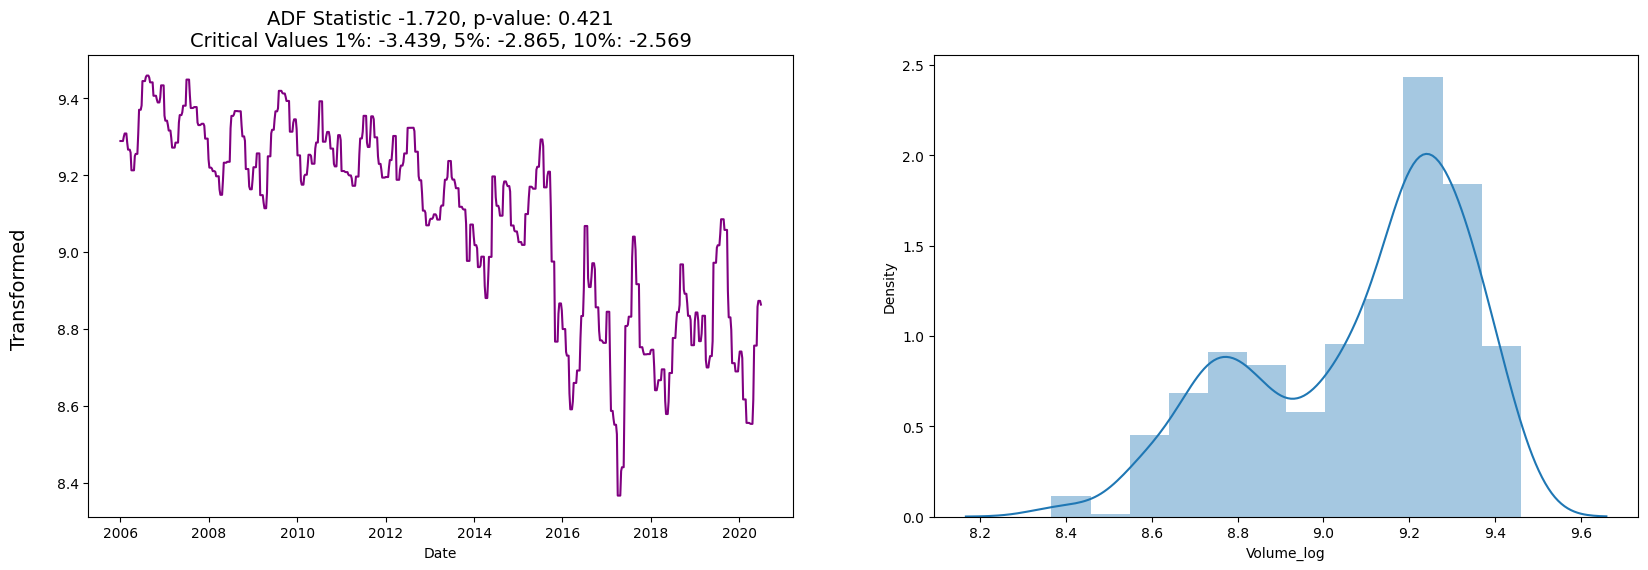

In [135]:
import numpy as np

df['Volume_log'] = np.log(abs(df['Volume']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['Volume_log'], 'Transformed \n', ax[0])

sns.distplot(df['Volume_log'], ax=ax[1])

###  Differencing

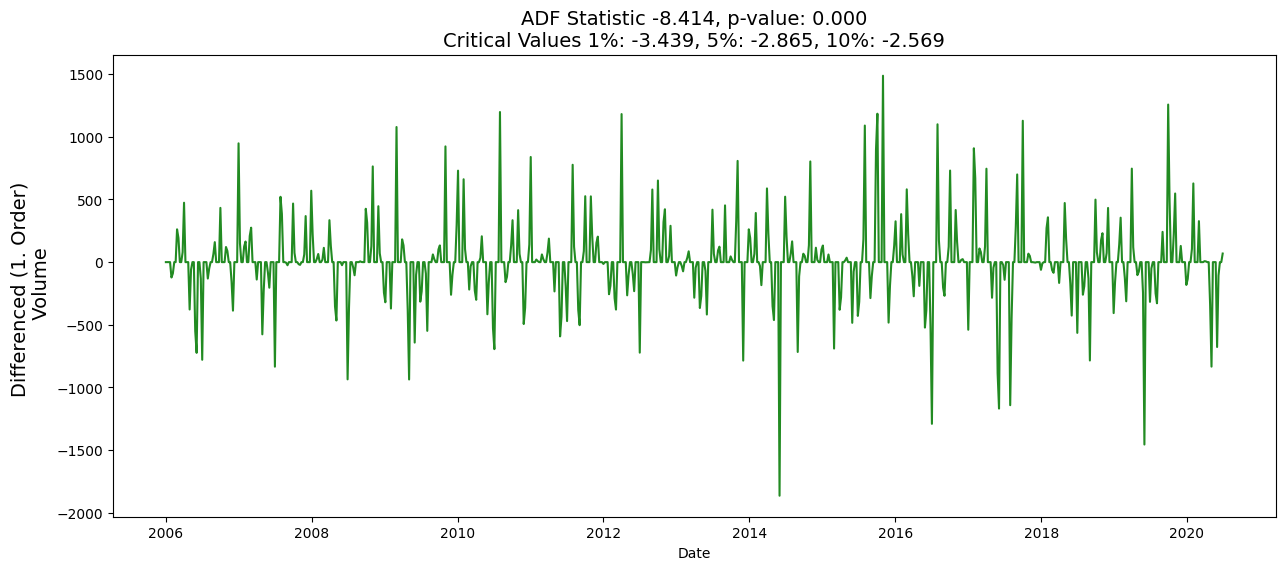

In [136]:
ts_diff = np.diff(df['Volume'])
df['Volume_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['Volume_diff_1'], 'Differenced (1. Order) \n Volume', ax)

##  Feature engineering

In [137]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['Date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['Date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

<ipython-input-137-9eeb8f86df86>:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year'] = pd.DatetimeIndex(df['Date']).weekofyear


,Date,year,month,day,day_of_year,week_of_year,quarter,season
0,2006-01-01,2006,1,1,1,52,1,1
1,2006-01-08,2006,1,8,8,1,1,1
2,2006-01-15,2006,1,15,15,2,1,1
3,2006-01-22,2006,1,22,22,3,1,1
4,2006-01-29,2006,1,29,29,4,1,1


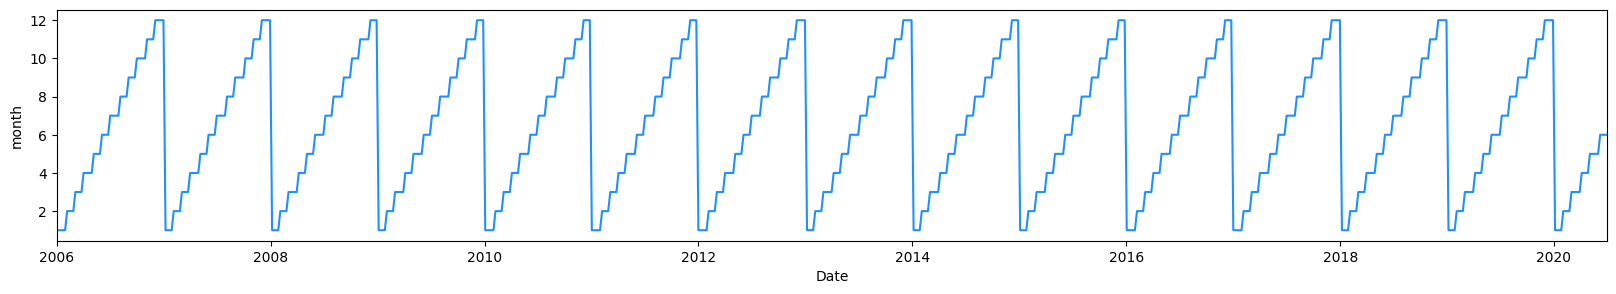

In [138]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['Date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2006, 1, 1), date(2020, 6, 30)])
plt.show()

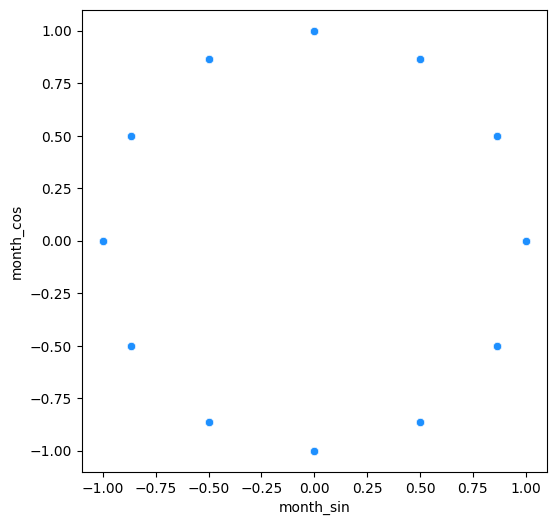

In [139]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

### Time-series descompositions

Time series decomposition involves conceptualizing a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

- **Level:** The average value in the series.
- **Trend:** The increasing or decreasing value in the series.
- **Seasonality:** The repeating short-term cycle in the series.
- **Noise:** The random variation in the series.

Decomposition provides a useful abstract model for understanding time series more comprehensively and enhances the analysis and forecasting of time series problems.

All series inherently possess a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:

**Additive:**
$$ y(t) = Level + Trend + Seasonality + Noise $$

**Multiplicative:**
$$ y(t) = Level \times Trend \times Seasonality \times Noise $$

In [140]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'Rainfall', 'Temperature', 'Volume', 'Hydrometry', 'Depth'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal


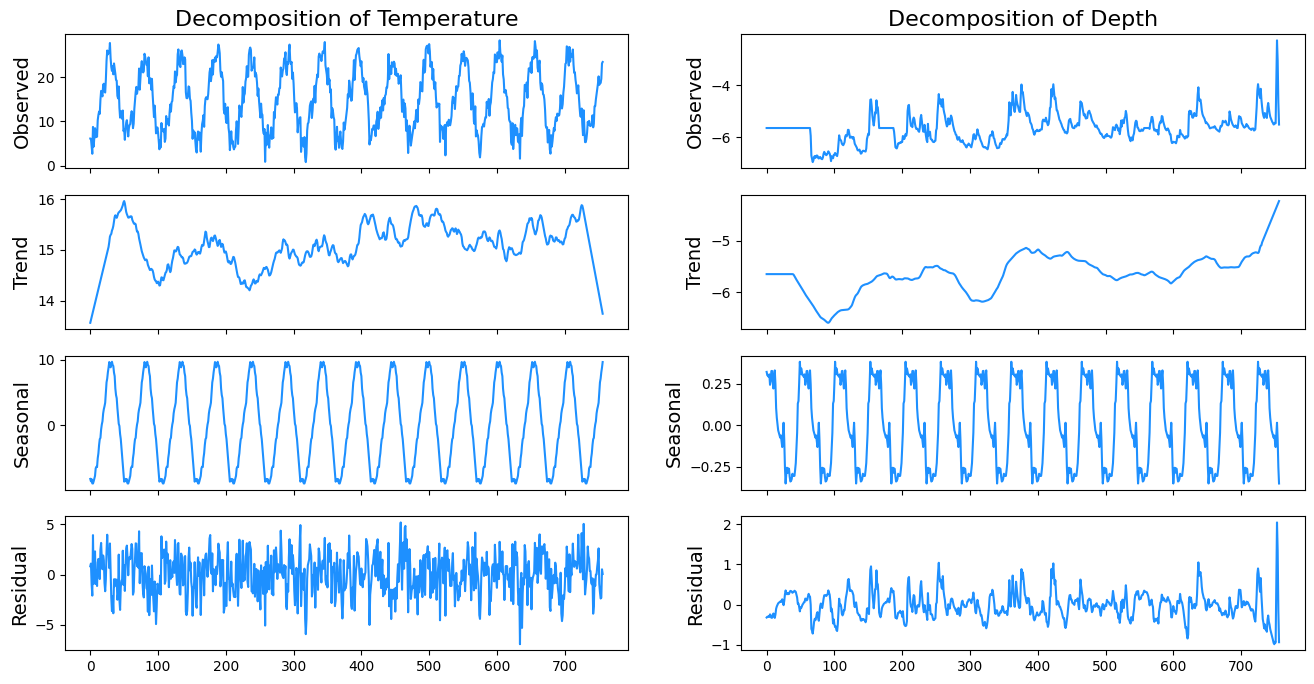

In [150]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['Temperature', 'Depth']):

    res = seasonal_decompose(df[column], period= 52, model='additive', extrapolate_trend= True)

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)

    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

In [151]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

## Data Analysis

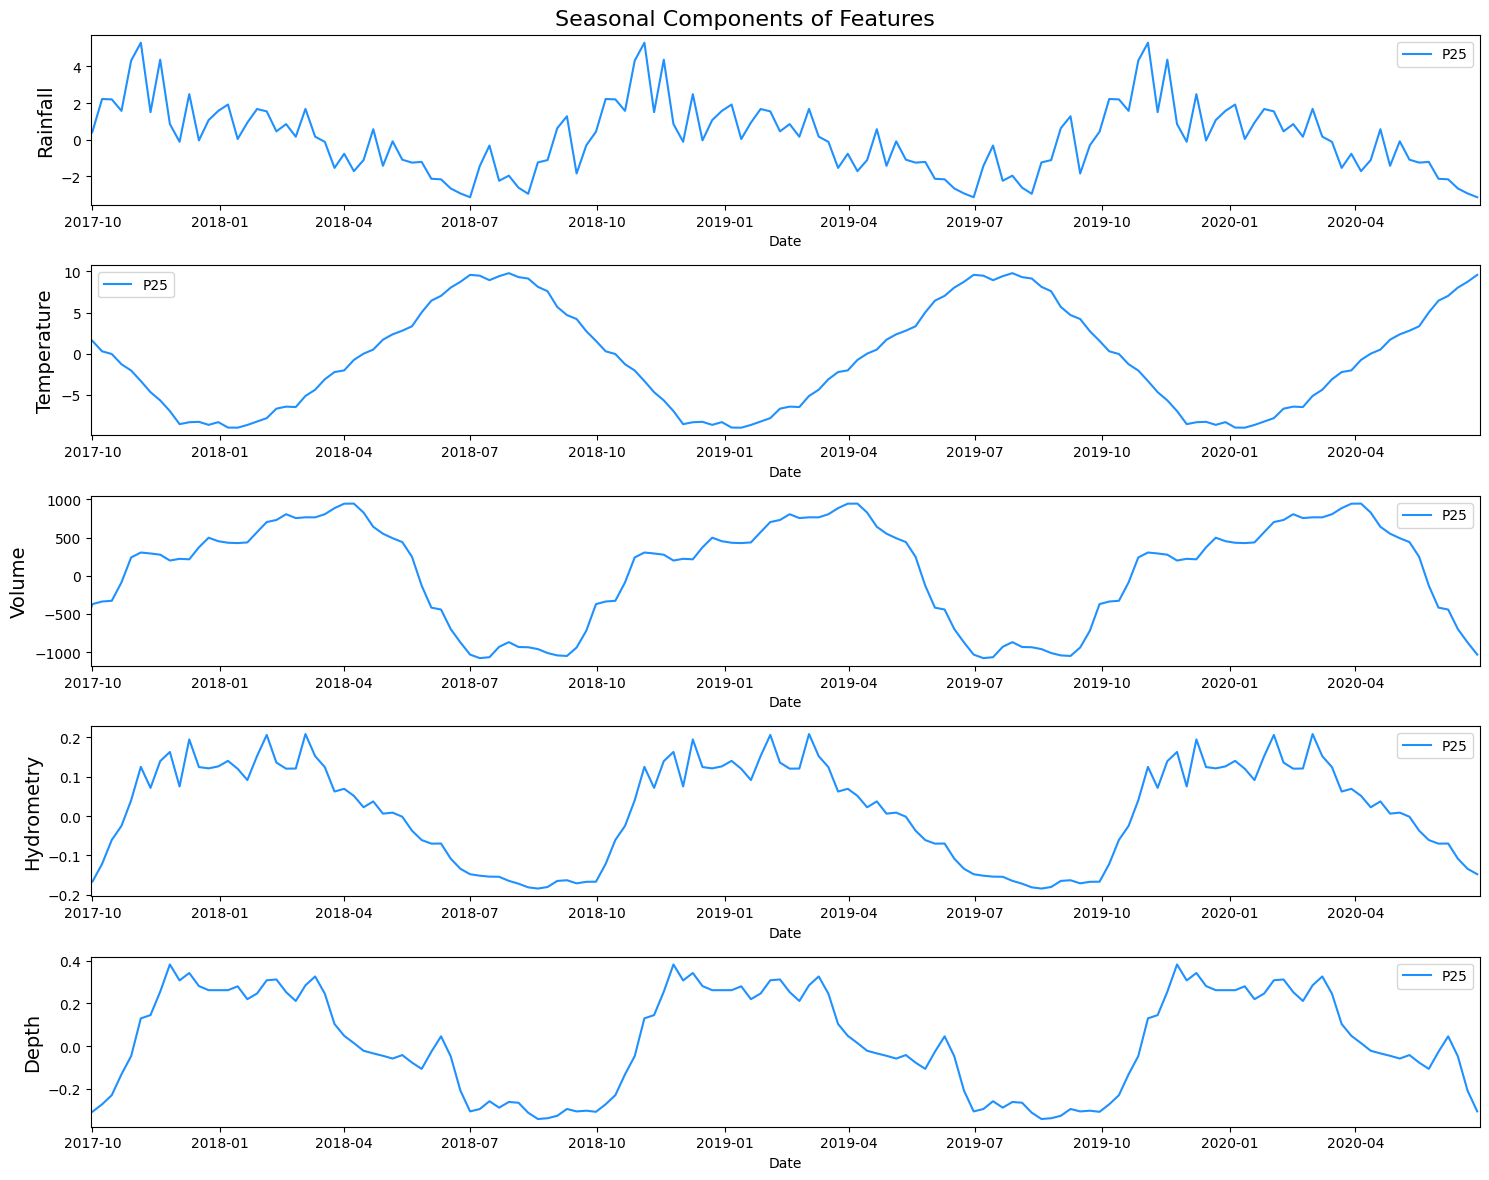

In [153]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['Date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

### Correlation analysis

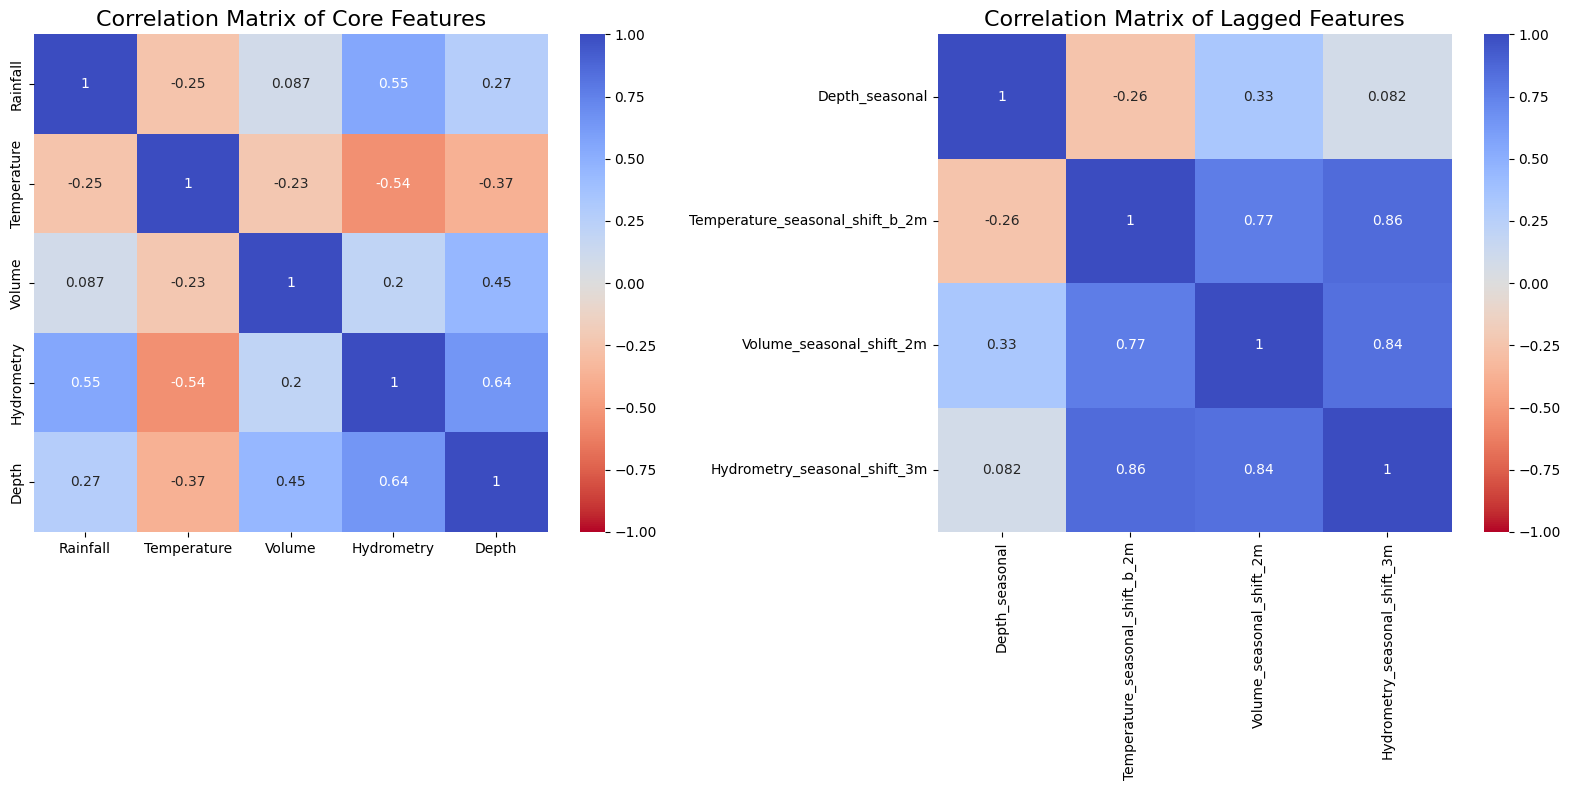

In [154]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'Depth_seasonal',
    'Temperature_seasonal_shift_b_2m',
    'Volume_seasonal_shift_2m',
    'Hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

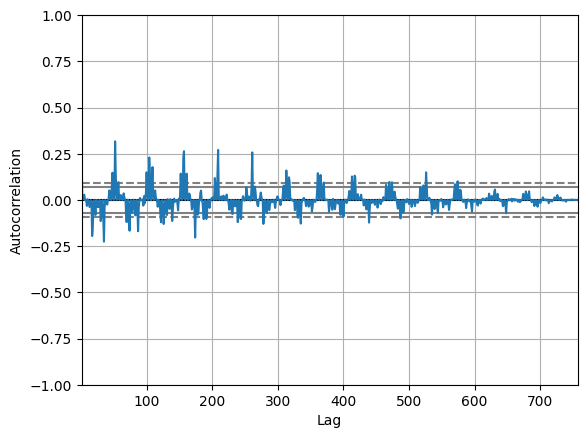

In [164]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['Volume_diff_1'])
plt.show()

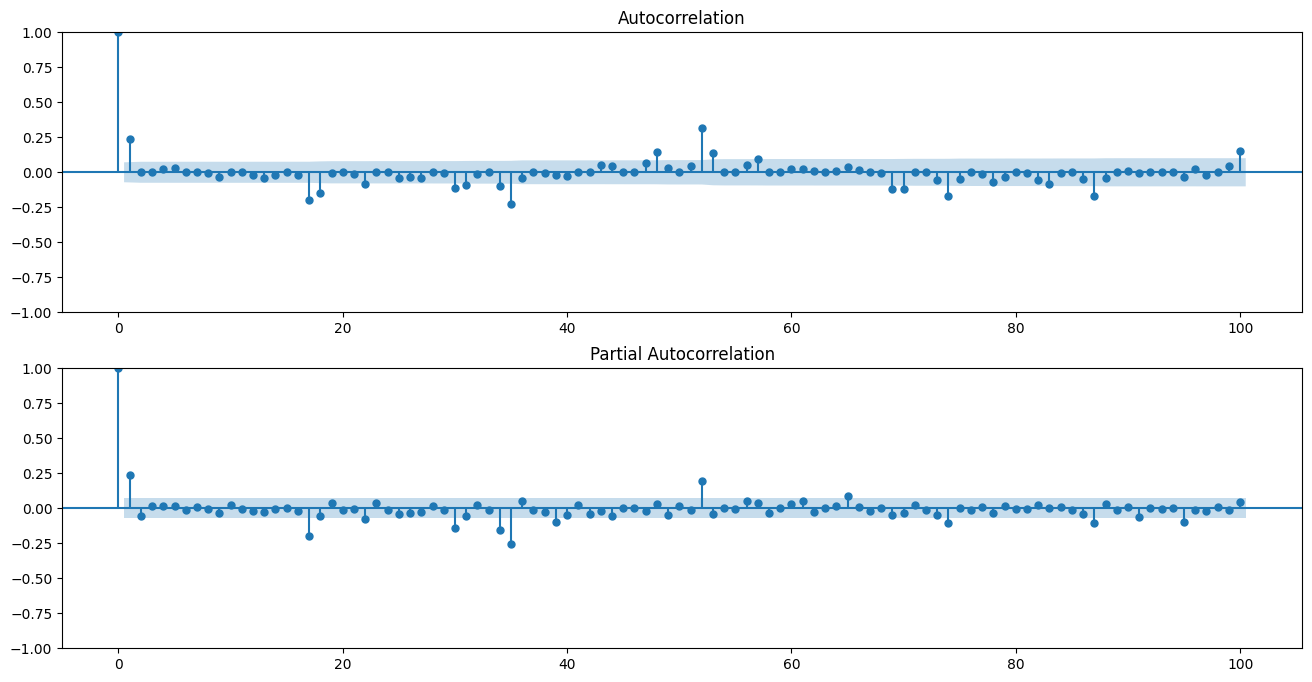

In [165]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['Volume_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['Volume_diff_1'], lags=100, ax=ax[1])

plt.show()

## Modeling

In [166]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['Date']
y = df['Volume']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

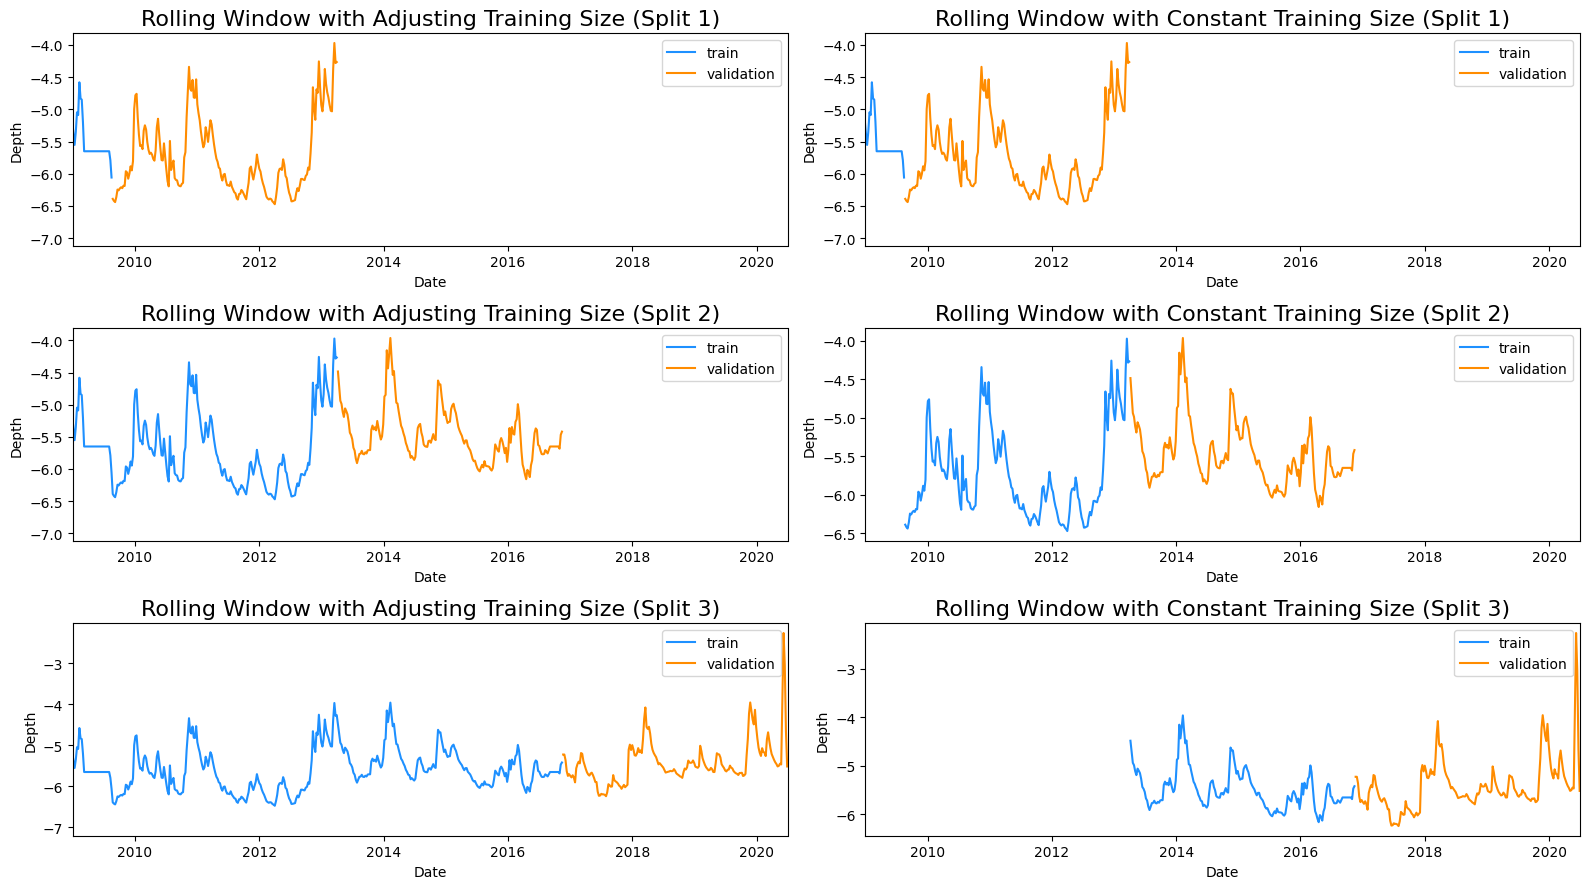

In [167]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train,
        y=y_train,
        ax=ax[i,0],
        color='dodgerblue',
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        ax=ax[i,1],
        color='dodgerblue',
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

### Modeling for Univariate Time Series

In [168]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['Date', 'Volume']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

643 114


### Prophet

In [179]:
!pip install prophet
!pip install colorama

In [180]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from colorama import Fore

from prophet import Prophet


# Train the model
model = Prophet()
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkbdtys05/61fll0_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkbdtys05/ezc7wptm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47497', 'data', 'file=/tmp/tmpkbdtys05/61fll0_y.json', 'init=/tmp/tmpkbdtys05/ezc7wptm.json', 'output', 'file=/tmp/tmpkbdtys05/prophet_modelmfvrjw5m/prophet_model-20231119172352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 2114.733971247161


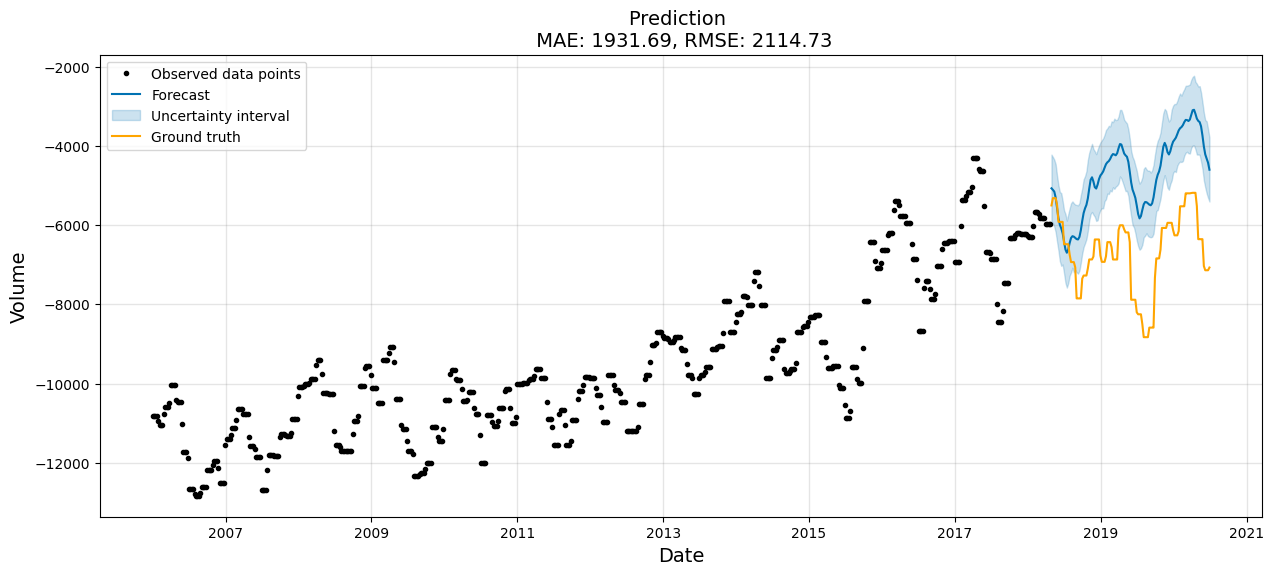

In [181]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Volume', fontsize=14)

plt.show()

### ARIMA

In [188]:
!pip install statsmodels

In [194]:
from statsmodels.tsa.arima.model import ARIMA

# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.forecast(114)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 1188.7338663923244
